### 09 Model Building & Grid Searching

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import Adam
# from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
import csv
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
random_state=42

In [127]:
!pip3 install xgboost

In [126]:
import sys
print(sys.base_prefix)

/Users/joshsungasong/anaconda3/envs/tensorflow


In [4]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 

In [7]:
model = pd.read_csv('model data snow day.csv')

In [8]:
#feature engineering
#engineer a number out of stage
model.stage.value_counts()

Lost                 926
Closed Won           295
Deal Signed           97
Contract Sent         75
Presentation          65
Invoice Sent          64
Proposal Sent         62
Qualified Lead        60
Research/Donation     27
Contract Expired       8
Contract Review        3
Pilot                  1
Name: stage, dtype: int64

#### Closed, Deal Signed, Invoice Sent = 1; otherwise 0

In [9]:
def translate_stage(stage):
    if stage in ['Closed Won', 'Deal Signed', 'Invoice Sent']:
        return(1)
    else:
        return (0)

In [10]:
model['y'] = model['stage'].apply(translate_stage)

In [11]:
model.shape

(1683, 20)

#### Feature engineering

In [12]:
#feature engineering
y = model['y']
X = model[['lat','lng', 
                'mobility_score',
                'carshare',
                'bikeshare',
                'ridehailing',
                'masstransit',
                'closest_ts',
                'within_one_tenth',
                'within_one_half',
                'within_one'
                ]]

#### Conducting a train/test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=14)

#### Calculating our baseline

In [14]:
#calculate baseline
print (y.value_counts())
print (1 - (456 / (1227+456)))

0    1227
1     456
Name: y, dtype: int64
0.7290552584670231


### Logistic Regression

In [48]:
%%time
logreg_params = {
   'penalty': ['l2'],
    'C': [1.0]
}

logreg_gd = GridSearchCV(LogisticRegression(), logreg_params, verbose=1, cv=5)
logreg_gd.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 50 ms, sys: 17 ms, total: 67 ms
Wall time: 66.3 ms


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [49]:
print(logreg_gd.best_score_)
print(logreg_gd.best_params_)
logreg_best = logreg_gd.best_estimator_
logreg_best

0.76740237691
{'C': 1.0, 'penalty': 'l2'}


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
logreg = LogisticRegression(C=1.0, penalty='l2', random_state=1)
logreg.fit(X_train, y_train)

print('Intercept', logreg.intercept_)
print('Coefficients', logreg.coef_)
print('Predicted probability', logreg.predict_proba(X)) 

Intercept [-0.46849039]
Coefficients [[ -4.35591648e-03   3.84445905e-03  -2.84860657e-03   7.09444251e-03
   -3.02356010e-03   1.93941170e-02  -3.54075826e-03  -4.06409755e-03
    1.45551237e+00  -1.74728813e-02   4.36833514e-04]]
Predicted probability [[ 0.37403717  0.62596283]
 [ 0.74463046  0.25536954]
 [ 0.78233926  0.21766074]
 ..., 
 [ 0.43173151  0.56826849]
 [ 0.90499069  0.09500931]
 [ 0.76690939  0.23309061]]


In [16]:
cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy').mean()

0.76742877749729543

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
logreg_pred = logreg.predict(X_test)

In [34]:
logreg_proba = logreg.predict_proba(X_test)
logreg_proba

array([[ 0.8895525 ,  0.1104475 ],
       [ 0.90017836,  0.09982164],
       [ 0.80331511,  0.19668489],
       ..., 
       [ 0.7134833 ,  0.2865167 ],
       [ 0.45295572,  0.54704428],
       [ 0.69911403,  0.30088597]])

#### Logistic Regression Confusion Matrix

In [36]:
logreg_CM = confusion_matrix(y_test, y_pred=logreg_pred, labels=None, sample_weight=None)
logreg_CM

array([[360,  19],
       [104,  22]])


- Specificity: 53.67%

- True negatives: 360
- False positives: 19
- False negatives: 104
- True positives: 22 

##### Specificity

In [43]:
print(360/(360+19))

0.9498680738786279


##### Sensitivity

In [41]:
print(22/(104+22))

0.1746031746031746


In [37]:
# plt.scatter(logreg_pred, ) #predictions vs. closed

In [27]:
from sklearn.metrics import classification_report

#### Logistic Regression Classification Report

In [29]:
print(classification_report(y_test, logreg_pred))

             precision    recall  f1-score   support

          0       0.78      0.95      0.85       379
          1       0.54      0.17      0.26       126

avg / total       0.72      0.76      0.71       505



- Precision: 72%


In [30]:
from sklearn.metrics import roc_auc_score

#### Logistic Regression ROC-AUC Score

In [32]:
roc_auc_score(y_test, logreg_pred, average='samples', )

0.56223562424090123

### Random Forest Classifier

#### Grid searching, hyperparameter tuning

In [77]:
%%time
ranfor_params = {
   'n_estimators': [500],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [3]

}

ranfor_gd = GridSearchCV(RandomForestClassifier(), ranfor_params, verbose=1, cv=5)
ranfor_gd.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:   53.0s finished


CPU times: user 52.8 s, sys: 231 ms, total: 53 s
Wall time: 53.8 s


In [78]:
print(ranfor_gd.best_score_)
print(ranfor_gd.best_params_)

0.768251273345
{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


#### Building our model with the tuned hyperparamters

In [82]:
ranfor_best = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_split=2,
                                     min_samples_leaf=1, max_features=3, random_state=2) 

In [83]:
ranfor_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [84]:
ranfor_best_scores = cross_val_score(ranfor_best, X_train, y_train, cv=5)
print(ranfor_best_scores)
print(np.mean(ranfor_best_scores))

[ 0.76271186  0.74576271  0.75847458  0.76595745  0.79148936]
0.764879192211


In [85]:
features_ranfor = pd.DataFrame(list(zip(X.columns,ranfor_best.feature_importances_))
                        ,columns=['feature','importance'])

Text(0,0.5,'Feature importance')

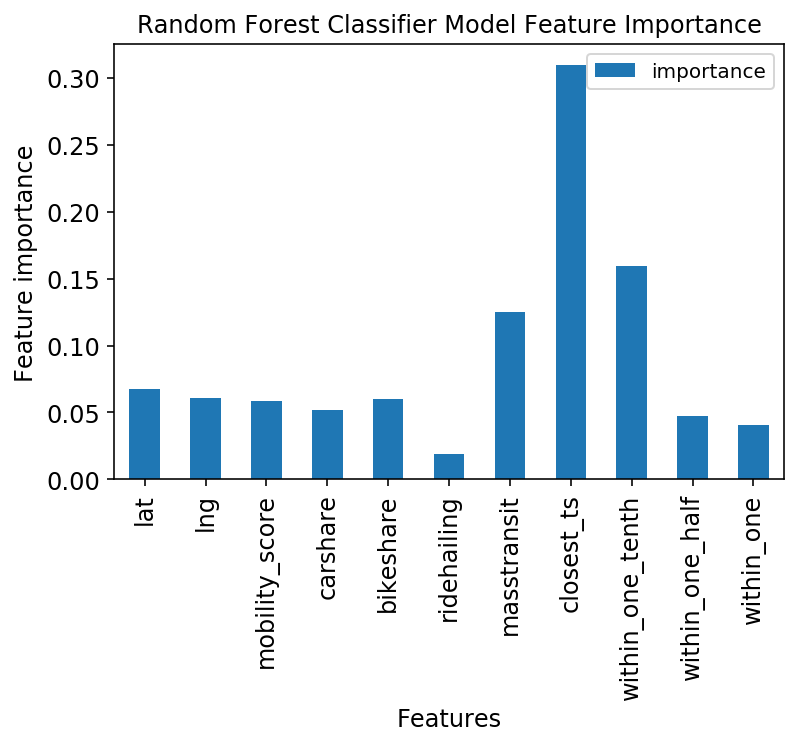

In [86]:
features_ranfor.plot(kind='bar', title='Random Forest Classifier Model Feature Importance', 
                        x='feature', y='importance', fontsize='large')
plt.xticks(rotation = 90)
plt.xlabel('Features', fontsize='large')
plt.ylabel('Feature importance', fontsize='large')

In [87]:
features_ranfor

,feature,importance
0,lat,0.067345
1,lng,0.060754
2,mobility_score,0.058451
3,carshare,0.051669
4,bikeshare,0.059965
5,ridehailing,0.018914
6,masstransit,0.125206
7,closest_ts,0.309527
8,within_one_tenth,0.159709
9,within_one_half,0.047618


In [88]:
ranfor_pred = ranfor_best.predict(X_test)

#### Random Forest Classifier Confusion Matrix

In [89]:
ranfor_CM = confusion_matrix(y_test, ranfor_pred)
ranfor_CM

array([[361,  18],
       [102,  24]])

- True positives: 24
- False negatives: 102
- False positives: 18
- True negatives: 361

##### Specificity

In [50]:
print(361/(361+18))

0.9525065963060686


##### Sensitivity

In [51]:
print(24/(24+102))

0.19047619047619047


#### Random Forest Classifier ROC-AUC Score

In [90]:
roc_auc_score(y_test, y_score=ranfor_pred)

0.57149139339112953

#### Random Forest Classifier Classification Report

In [91]:
print(classification_report(y_test, ranfor_pred))

             precision    recall  f1-score   support

          0       0.78      0.95      0.86       379
          1       0.57      0.19      0.29       126

avg / total       0.73      0.76      0.71       505



- Precision: 73%
- Recall/sensitivity: 76%

### Gradient Boost Classifier

#### Grid searching, hyperparamter tuning

In [97]:
%%time
gradboost_params = {
  'loss': ['exponential'],
   'learning_rate': [0.01],
    'n_estimators': [300],
    'max_depth': [1],
    'min_samples_leaf': [1],
    'max_features': [8]
}

gradboost_gd = GridSearchCV(GradientBoostingClassifier(), gradboost_params, verbose=1, cv=5)
gradboost_gd.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
CPU times: user 5.77 s, sys: 31.3 ms, total: 5.8 s
Wall time: 5.84 s


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    5.7s finished


In [98]:
print(gradboost_gd.best_score_)
print(gradboost_gd.best_params_)

0.769100169779
{'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 1, 'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 300}


In [28]:
gradboost_best = GradientBoostingClassifier(loss='exponential', learning_rate=0.01, 
                                            n_estimators=300, max_depth=1, min_samples_leaf=1, max_features=8,
                                           random_state=3) 
gradboost_best.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='exponential', max_depth=1,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=3, subsample=1.0, verbose=0,
              warm_start=False)

In [29]:
gradboost_scores = cross_val_score(gradboost_best, X_train, y_train, cv=5)
print(gradboost_scores)
print(np.mean(gradboost_scores))

[ 0.77118644  0.74576271  0.75423729  0.7787234   0.79574468]
0.769130905157


In [30]:
features_gradboost = pd.DataFrame(list(zip(X.columns,gradboost_best.feature_importances_))
                        ,columns=['feature','importance']) 

Text(0,0.5,'Feature importance')

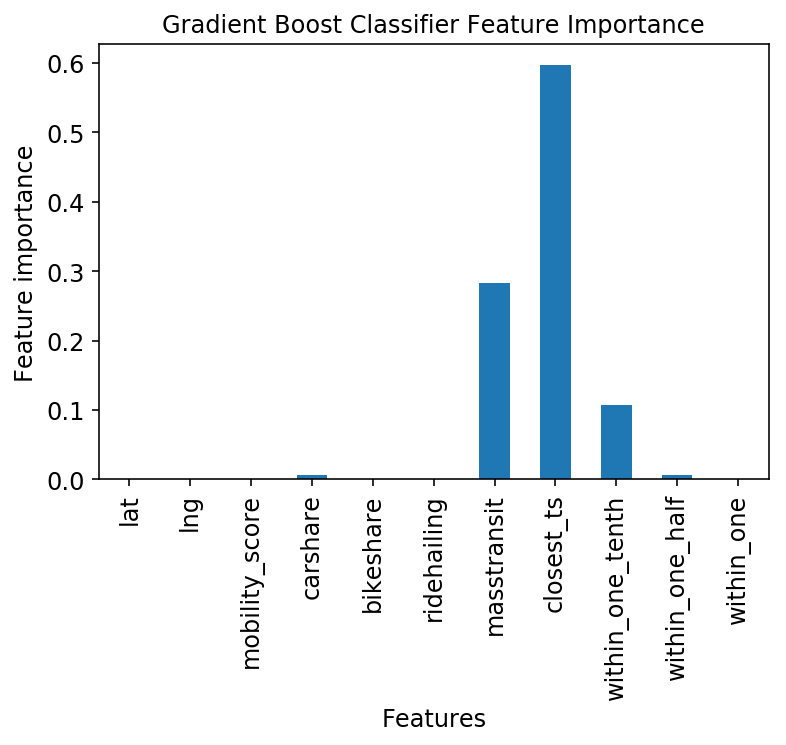

In [31]:
features_gradboost.plot(kind='bar', title='Gradient Boost Classifier Feature Importance', 
                        x='feature', y='importance', fontsize='large', sort_columns=True, legend=False)
plt.xticks(rotation = 90)
plt.xlabel('Features', fontsize='large')
plt.ylabel('Feature importance', fontsize='large')

In [32]:
features_gradboost

,feature,importance
0,lat,0.000000
1,lng,0.000000
2,mobility_score,0.000000
3,carshare,0.006667
4,bikeshare,0.000000
5,ridehailing,0.000000
6,masstransit,0.283333
7,closest_ts,0.596667
8,within_one_tenth,0.106667
9,within_one_half,0.006667


In [33]:
gradboost_pred = gradboost_best.predict(X_test)

#### Gradient Boost Classifier Confusion Matrix

In [34]:
gradboost_CM = confusion_matrix(y_test, gradboost_pred)
gradboost_CM

array([[358,  21],
       [102,  24]])

- True positives: 24
- False negatives: 102
- False positives: 21
- True negatives: 358

##### Specificity

In [53]:
print(358/(358+21))

0.9445910290237467


##### Sensitivity

In [54]:
print(24/(24+102))

0.19047619047619047


#### Gradient Boost Classifier ROC-AUC Score

In [35]:
roc_auc_score(y_test, gradboost_pred)

0.56753360974996858

#### Gradient Boost Classifier Classification Report

In [36]:
print(classification_report(y_test, gradboost_pred))

             precision    recall  f1-score   support

          0       0.78      0.94      0.85       379
          1       0.53      0.19      0.28       126

avg / total       0.72      0.76      0.71       505



- Precision: 72%
- Recall: 76%

### AdaBoost Classifier

#### Grid Searching, Hyperparameter tuning

In [125]:
%%time
adaboost_params = {
   'n_estimators': [25],
    'learning_rate': [0.1],
    
}

adaboost_gd = GridSearchCV(AdaBoostClassifier(), adaboost_params, verbose=1, cv=5)
adaboost_gd.fit(X_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: user 1.56 s, sys: 29.9 ms, total: 1.59 s
Wall time: 1.61 s


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.6s finished


In [127]:
print(adaboost_gd.best_score_)
print(adaboost_gd.best_params_)

0.769100169779
{'learning_rate': 0.1, 'n_estimators': 25}


#### Building the model with the tuned hyperparamters

In [37]:
adaboost_best = AdaBoostClassifier(learning_rate=0.1, n_estimators=25, random_state=4)
adaboost_best.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=25, random_state=4)

In [38]:
adaboost_scores = cross_val_score(adaboost_best, X_train, y_train, cv=5)
print(adaboost_scores)
print(np.mean(adaboost_scores)) 

[ 0.77966102  0.74576271  0.75        0.77446809  0.79574468]
0.769127298954


#### AdaBoost Classifier Feature Importance

In [39]:
features_adaboost = pd.DataFrame(list(zip(X.columns,adaboost_best.feature_importances_))
                        ,columns=['feature','importance']) 

Text(0,0.5,'Feature importance')

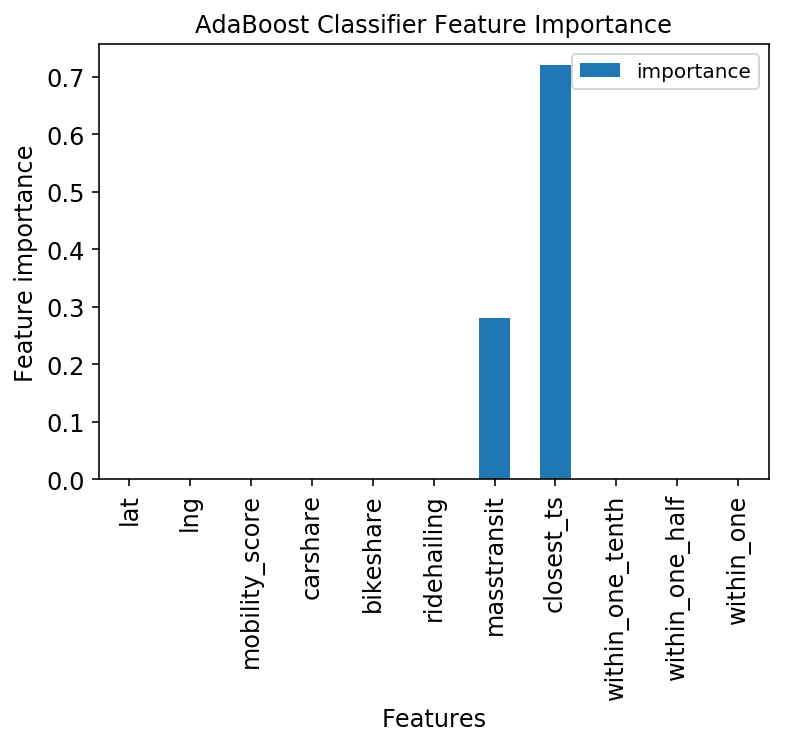

In [40]:
features_adaboost.plot(kind='bar', title='AdaBoost Classifier Feature Importance', 
                        x='feature', y='importance', fontsize='large')
plt.xticks(rotation = 90)
plt.xlabel('Features', fontsize='large')
plt.ylabel('Feature importance', fontsize='large')

In [41]:
features_adaboost 

,feature,importance
0,lat,0.00
1,lng,0.00
2,mobility_score,0.00
3,carshare,0.00
4,bikeshare,0.00
5,ridehailing,0.00
6,masstransit,0.28
7,closest_ts,0.72
8,within_one_tenth,0.00
9,within_one_half,0.00


In [42]:
adaboost_pred = adaboost_best.predict(X_test)

#### AdaBoost Classifier Confusion Matrix

In [43]:
adaboost_CM = confusion_matrix(y_test, adaboost_pred)
adaboost_CM

array([[358,  21],
       [101,  25]])

- True positives: 25
- False negatives: 101
- False positives: 21
- True negatives: 358

##### Specificity

In [56]:
print(358/(358+21))

0.9445910290237467


##### Sensitivity

In [57]:
print(25/(25+101))

0.1984126984126984


#### AdaBoost Classifier ROC-AUC score

In [44]:
roc_auc_score(y_test, adaboost_pred)

0.57150186371822254

#### AdaBoost Classifier Classification Report

In [45]:
print(classification_report(y_test, adaboost_pred))

             precision    recall  f1-score   support

          0       0.78      0.94      0.85       379
          1       0.54      0.20      0.29       126

avg / total       0.72      0.76      0.71       505



- Precision: 72%

### XGBoost

In [11]:
%%time
xgb_params = {
   'max_depth': [3],
   'learning_rate': [0.01],
    'n_estimators': [125],
    'gamma': [0.05],
    'min_child_weight': [1],
    'subsample': [1.0],
    'colsample_bytree': [0.6],
    'reg_lambda': [0.01],
    'reg_alpha': [0]
}

xgboost_gd = GridSearchCV(XGBClassifier(), xgb_params, verbose=1, cv=5)
xgboost_gd.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined

In [162]:
print(xgboost_gd.best_score_)
print(xgboost_gd.best_params_)

0.76740237691
{'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 125, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 1.0}


In [46]:
xgboost_best = XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=125, gamma=0.05, min_child_weight=1.0,
                            subsample=1.0, colsample_bytree=0.6, reg_lambda=0.01, reg_alpha=0, random_state=5)
xgboost_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.05, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=125, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=5, reg_alpha=0,
       reg_lambda=0.01, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)

In [47]:
xgb_scores = cross_val_score(xgboost_best, X_train, y_train, cv=5)
print(xgb_scores)
print(np.mean(xgb_scores)) 

[ 0.76694915  0.74576271  0.75847458  0.77021277  0.79148936]
0.766577713668


In [48]:
features_xgboost = pd.DataFrame(list(zip(X.columns,xgboost_best.feature_importances_))
                        ,columns=['feature','importance']) 

#### Extreme Gradient Boost Classifier Feature Importance

Text(0,0.5,'Feature importance')

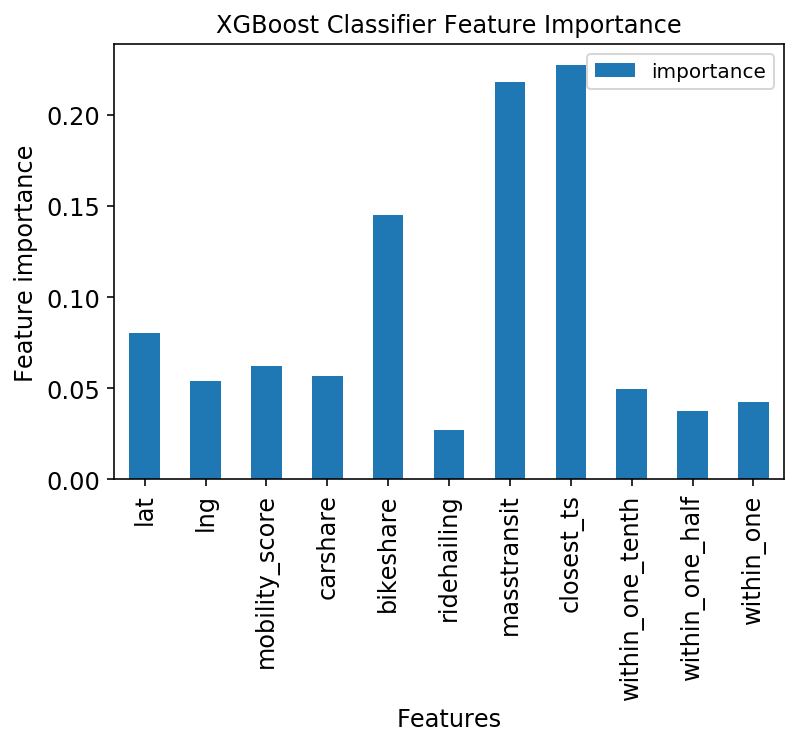

In [49]:
features_xgboost.plot(kind='bar', title='XGBoost Classifier Feature Importance', 
                        x='feature', y='importance', fontsize='large')
plt.xticks(rotation = 90)
plt.xlabel('Features', fontsize='large')
plt.ylabel('Feature importance', fontsize='large')

In [50]:
features_xgboost

,feature,importance
0,lat,0.080094
1,lng,0.054181
2,mobility_score,0.062426
3,carshare,0.056537
4,bikeshare,0.144876
5,ridehailing,0.027091
6,masstransit,0.217903
7,closest_ts,0.227326
8,within_one_tenth,0.049470
9,within_one_half,0.037691


In [51]:
xgb_pred = xgboost_best.predict(X_test)

#### Extreme Gradient Boost Classifier Confusion Matrix

In [52]:
xgb_CM = confusion_matrix(xgb_pred, y_test)
xgb_CM

array([[361, 103],
       [ 18,  23]])

- True positives: 23
- False positives: 103
- False negatives: 18
- True negatives: 361

##### Specificity

In [58]:
print(361/(361+103))

0.7780172413793104


##### Sensitivity

In [59]:
print(23/(23+18))

0.5609756097560976


#### Extreme Gradient Boost Classifier ROC-AUC Score

In [53]:
roc_auc_score(y_test, xgb_pred)

0.56752313942287558

#### Extreme Gradient Boost Classifier Classification Report

In [54]:
print(classification_report(xgb_pred, y_test))

             precision    recall  f1-score   support

          0       0.95      0.78      0.86       464
          1       0.18      0.56      0.28        41

avg / total       0.89      0.76      0.81       505



- Precision: 89%

### Extra Trees Classifier

In [193]:
%%time
ext_params = {
    'max_features': [2],
   'max_depth': [8],
    'min_samples_split': [15],
    'n_estimators': [800],
    'min_samples_leaf': [1],
    'criterion': ['entropy'],
}

ext_gd = GridSearchCV(ExtraTreesClassifier(), ext_params, verbose=1, cv=5)
ext_gd.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.2s finished


CPU times: user 9.86 s, sys: 78.8 ms, total: 9.94 s
Wall time: 10.1 s


In [194]:
print(ext_gd.best_score_)
print(ext_gd.best_params_)

0.761460101868
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 800}


In [55]:
ext_best = ExtraTreesClassifier(max_depth=8, min_samples_leaf=1, n_estimators=800, min_samples_split=15,
                            max_features=2, criterion='entropy', random_state=6)
ext_best.fit(X_train, y_train)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=8, max_features=2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
           oob_score=False, random_state=6, verbose=0, warm_start=False)

In [56]:
ext_scores = cross_val_score(ext_best, X_train, y_train, cv=5)
print(ext_scores)
print(np.mean(ext_scores)) 

[ 0.75847458  0.74152542  0.75423729  0.76170213  0.7787234 ]
0.75893256401


#### Extra Trees Classifier Feature Importance

In [57]:
features_ext = pd.DataFrame(list(zip(X.columns,ext_best.feature_importances_))
                        ,columns=['feature','importance']) 

Text(0,0.5,'Feature importance')

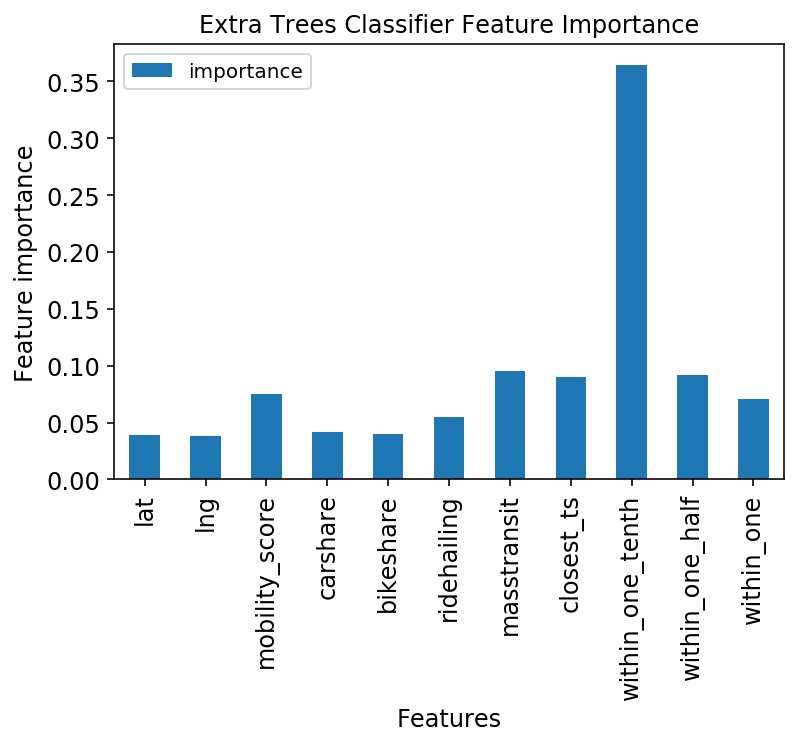

In [58]:
features_ext.plot(kind='bar', title='Extra Trees Classifier Feature Importance', 
                        x='feature', y='importance', fontsize='large')
plt.xticks(rotation = 90)
plt.xlabel('Features', fontsize='large')
plt.ylabel('Feature importance', fontsize='large')

In [60]:
ext_pred = ext_best.predict(X_test)

#### Extreme Trees Classifier Confusion Matrix

In [62]:
ext_CM = confusion_matrix(y_test, ext_pred)
ext_CM

array([[371,   8],
       [105,  21]])

- True positives: 21
- False negatives: 105
- False positives: 8
- True negatives: 371

##### Specificity

In [60]:
print(371/(371+8))

0.978891820580475


##### Sensitivity

In [61]:
print(21/(21+105))

0.16666666666666666


#### Extreme Trees Classifier ROC-AUC Score

In [63]:
roc_auc_score(y_test, ext_pred)

0.57277924362357091

#### Extreme Trees Classifier Classification Report

In [66]:
print(classification_report(y_test, ext_pred))

             precision    recall  f1-score   support

          0       0.78      0.98      0.87       379
          1       0.72      0.17      0.27       126

avg / total       0.77      0.78      0.72       505



- Precision: 77%

### Bagging Classifier

In [23]:
%%time
bag_params = {
    'n_estimators':[800],
    'max_samples':[50],
    'bootstrap':[False],
    'bootstrap_features':[True]
    
}

bag_gd = GridSearchCV(BaggingClassifier(), bag_params, verbose=1, cv=5)
bag_gd.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   19.5s finished


CPU times: user 19.8 s, sys: 155 ms, total: 20 s
Wall time: 20.3 s


In [24]:
print(bag_gd.best_score_)
print(bag_gd.best_params_)

0.7682512733446519
{'bootstrap': False, 'bootstrap_features': True, 'max_samples': 50, 'n_estimators': 800}


In [67]:
bag_best = BaggingClassifier(n_estimators=800, max_samples=50,bootstrap=False, bootstrap_features=True, random_state=7)
bag_best.fit(X_train, y_train)


BaggingClassifier(base_estimator=None, bootstrap=False,
         bootstrap_features=True, max_features=1.0, max_samples=50,
         n_estimators=800, n_jobs=1, oob_score=False, random_state=7,
         verbose=0, warm_start=False)

In [68]:
bag_scores = cross_val_score(bag_best, X_train, y_train, cv=5)
print(bag_scores)
print(np.mean(bag_scores)) 

[ 0.76694915  0.74576271  0.76271186  0.76170213  0.78297872]
0.764020915975


In [70]:
bag_pred = bag_best.predict(X_test)

#### Bagging Trees Classifier Confusion Matrix

In [71]:
bag_CM = confusion_matrix(y_test, bag_pred)
bag_CM

array([[365,  14],
       [ 99,  27]])

- True positives: 27
- False negatives: 99
- False positives: 14
- True negatives: 365

##### Specificity

In [63]:
print(365/(365+14))

0.9630606860158312


##### Sensitivity

In [64]:
print(27/(27+99))

0.21428571428571427


#### Bagging Trees Classifier ROC-AUC Score

In [72]:
roc_auc_score(y_test, bag_pred)

0.58867320015077274

#### Bagging Trees Classifier Classification Report

In [73]:
print(classification_report(y_test, bag_pred))

             precision    recall  f1-score   support

          0       0.79      0.96      0.87       379
          1       0.66      0.21      0.32       126

avg / total       0.75      0.78      0.73       505



- Precision: 75%

### Model Evaluation

Cross Validation Scores
- Logistic Regression: 76.74%
- Random Forest Classifier: 76.49%
- AdaBoost Classifier: 76.91%
- Gradient Boost Classifier: 76.91%
- Extreme Gradient Boost Classifier: 76.67%
- Extreme Trees Classifier: 75.89%
- Bagging Classifier: 76.40%